In [1]:
import pandas as pd
import numpy as np

In [2]:
%matplotlib inline
import seaborn as sns

In [3]:
sns.set(rc={'figure.figsize': (9, 6)})

In [4]:
events_data = pd.read_csv('1_10_data/event_data_train.csv.zip')

In [5]:
submissions_data = pd.read_csv('1_10_data/submissions_data_train.csv.zip')

In [6]:
events_data.head()

,step_id,timestamp,action,user_id
0,32815,1434340848,viewed,17632
1,32815,1434340848,passed,17632
2,32815,1434340848,discovered,17632
3,32811,1434340895,discovered,17632
4,32811,1434340895,viewed,17632


In [7]:
submissions_data.head()

,step_id,timestamp,submission_status,user_id
0,31971,1434349275,correct,15853
1,31972,1434348300,correct,15853
2,31972,1478852149,wrong,15853
3,31972,1478852164,correct,15853
4,31976,1434348123,wrong,15853


In [8]:
events_data['date'] = pd.to_datetime(events_data.timestamp, unit='s')
events_data['day'] = events_data.date.dt.date;

In [9]:
submissions_data['date'] = pd.to_datetime(submissions_data.timestamp, unit='s')
submissions_data['day'] = submissions_data.date.dt.date;

In [10]:
events_data.head()

,step_id,timestamp,action,user_id,date,day
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15


In [11]:
submissions_data.head()

,step_id,timestamp,submission_status,user_id,date,day
0,31971,1434349275,correct,15853,2015-06-15 06:21:15,2015-06-15
1,31972,1434348300,correct,15853,2015-06-15 06:05:00,2015-06-15
2,31972,1478852149,wrong,15853,2016-11-11 08:15:49,2016-11-11
3,31972,1478852164,correct,15853,2016-11-11 08:16:04,2016-11-11
4,31976,1434348123,wrong,15853,2015-06-15 06:02:03,2015-06-15


<AxesSubplot:xlabel='day'>

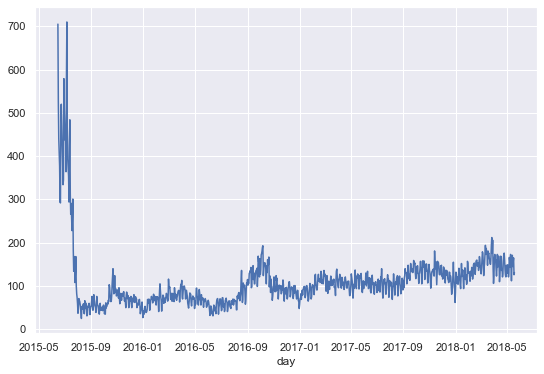

In [12]:
events_data.groupby('day').user_id.nunique().plot()

<AxesSubplot:>

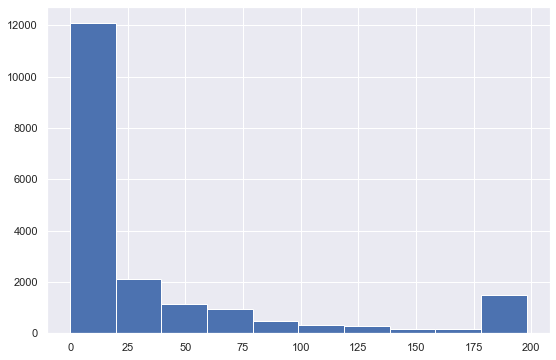

In [13]:
events_data.pivot_table(
    index='user_id',
    columns='action',
    values='step_id',
    aggfunc='count',
    fill_value=0
).reset_index()['discovered'].hist()

In [14]:
users_scores = submissions_data.pivot_table(
    index='user_id',
    columns='submission_status',
    values='step_id',
    aggfunc='count',
    fill_value=0
).reset_index()

In [15]:
users_scores.head()

submission_status,user_id,correct,wrong
0,2,2,0
1,3,29,23
2,5,2,2
3,8,9,21
4,14,0,1


In [16]:
users_data = (events_data.groupby('user_id', as_index=False)
              .agg({'timestamp': 'max'})
              .rename({'timestamp': 'last_timestamp'}, axis='columns'))

In [17]:
now = 1526772811
drop_out_threshold = 2592000

In [18]:
users_data['is_gone_user'] = (now - users_data.last_timestamp) > drop_out_threshold

In [19]:
users_scores = submissions_data.pivot_table(
    index='user_id',
    columns='submission_status',
    values='step_id',
    aggfunc='count',
    fill_value=0
).reset_index()

In [20]:
users_data = users_data.merge(users_scores, on='user_id', how='outer')
users_data = users_data.fillna(0)

In [21]:
users_invent_data = events_data.pivot_table(index='user_id',
                                            columns='action',
                                            values='step_id',
                                            aggfunc='count',
                                            fill_value=0
                                            ).reset_index()

In [22]:
users_data = users_data.merge(users_invent_data, how='outer')

In [23]:
users_days = events_data.groupby('user_id').day.nunique()

In [24]:
users_days.to_frame().reset_index()

,user_id,day
0,1,1
1,2,2
2,3,7
3,5,2
4,7,1
...,...,...
19229,26790,4
19230,26793,1
19231,26794,9
19232,26797,2


In [25]:
users_data = users_data.merge(users_days, on='user_id', how='outer')
users_data['passed_course'] = users_data.passed > 170

In [26]:
users_data.head()

,user_id,last_timestamp,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed,day,passed_course
0,1,1472827464,True,0.0,0.0,1,0,0,1,1,False
1,2,1519226966,True,2.0,0.0,9,9,2,10,2,False
2,3,1444581588,True,29.0,23.0,91,87,30,192,7,False
3,5,1499859939,True,2.0,2.0,11,11,4,12,2,False
4,7,1521634660,True,0.0,0.0,1,1,0,1,1,False


In [27]:
user_min_time = (events_data.groupby('user_id', as_index=False)
                 .agg({'timestamp':'min'})
                 .rename(columns={'timestamp': 'min_timestamp'}))

In [28]:
users_data = users_data.merge(user_min_time, on='user_id', how='outer')

In [29]:
users_data.head()

,user_id,last_timestamp,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed,day,passed_course,min_timestamp
0,1,1472827464,True,0.0,0.0,1,0,0,1,1,False,1472827464
1,2,1519226966,True,2.0,0.0,9,9,2,10,2,False,1514383364
2,3,1444581588,True,29.0,23.0,91,87,30,192,7,False,1434358476
3,5,1499859939,True,2.0,2.0,11,11,4,12,2,False,1466156809
4,7,1521634660,True,0.0,0.0,1,1,0,1,1,False,1521634660


In [30]:
events_data.head()

,step_id,timestamp,action,user_id,date,day
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15


In [31]:
learning_time_threshold = 3 * 24 * 60 * 60
learning_time_threshold

259200

In [32]:
user_learning_time_threshold = user_min_time['min_timestamp'] + learning_time_threshold

In [33]:
user_min_time['user_learning_time_threshold'] = user_learning_time_threshold

In [34]:
events_data = events_data.merge(user_min_time[['user_id', 'user_learning_time_threshold']], on='user_id', how='outer')

In [35]:
events_data_train = events_data[events_data['timestamp'] <= events_data['user_learning_time_threshold']]

In [36]:
events_data_train.head()

,step_id,timestamp,action,user_id,date,day,user_learning_time_threshold
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15,1434600048
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15,1434600048
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15,1434600048
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15,1434600048
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15,1434600048
